Here we train the support states directly using BPTT, which similarly suffers from the vanishing gradient problem.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 2.6.0+cu124
Cuda available: False
Device: cpu


Discrete dynamics:

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + \mathbf{f}_{base}(\mathbf{x}^{t-1}) + CW^T\psi(\mathbf{x}^{t-1})\right).$$

where
$\psi(\mathbf{x}) = \tanh(J_\psi \mathbf{x})$ and $(J_\psi)_{id} \sim \mathcal{N}(0, g)$.

For now we leave $\mathbf{f}_{base} = 0$ so that

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + CW^T\psi(\mathbf{x}^{t-1})\right).$$

In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def ker(x_1, x_2):
    return psi_fn(x_1)@psi_fn(x_2)

def advance(x, z, alphas, x_stars, u):
    temp = torch.zeros((D, 1))
    for alpha, x_star in zip(alphas, x_stars):
        temp += alpha.reshape((D, 1))*ker(x.reshape((D,)), x_star.reshape((D,)))
    x_next = x + DT/TAU*(-x + C@temp + B@u)
    return x_next

## Demo of vanishing gradient problem w BPTT

First a successful example where training is successful since the delay is short

In [3]:
# smln params
T = 1.6
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
N_SS = 2  ## num support states
x_0 = torch.tensor([[.001, .001]], device=device).T
alphas_0 = torch.zeros((N_SS, D), device=device)
# x_stars_0 = torch.zeros((N_SS, D), device=device)
x_stars_0 = torch.tensor([[1, 0.], [-1., 0]])

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

In [4]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[160, 960], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [5]:
lr = .01
nepoch = 40

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])
    
alphas = alphas_0.clone().detach()
alphas.requires_grad = True
x_stars = x_stars_0.clone().detach()
x_stars.requires_grad = True

losses = []
alphas_save = []
x_stars_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]

    for ct in range(1, IT):
        x_hat_next = advance(x_hats[-1], z_hats[-1], alphas, x_stars, us[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        alphas -= lr*alphas.grad
        alphas.grad.zero_()
        
        x_stars -= lr*x_stars.grad
        x_stars.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        alphas_save.append(alphas.clone().detach().numpy())
        x_stars_save.append(x_stars.clone().detach().numpy())

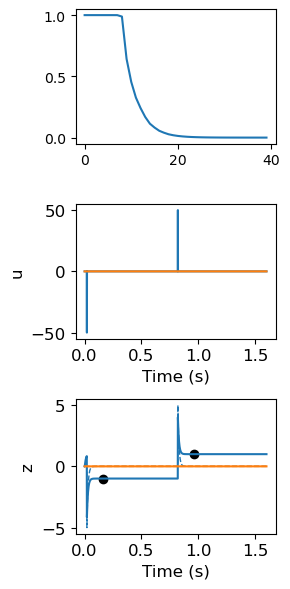

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(3, 6), tight_layout=True)

axs[0].plot(range(nepoch), losses)
# set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

# fig.savefig('ms/4_flip_flop_bptt_vanish_grad.svg')

Longer delay example where training fails

In [7]:
# smln params
T = 1.6
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
N_SS = 2  ## num support states
x_0 = torch.tensor([[.001, .001]], device=device).T
alphas_0 = torch.zeros((N_SS, D), device=device)
# x_stars_0 = torch.zeros((N_SS, D), device=device)
x_stars_0 = torch.tensor([[1, 0.], [-1., 0]])

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

In [8]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[760, 1560], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [9]:
lr = .01
nepoch = 40

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])
    
alphas = alphas_0.clone().detach()
alphas.requires_grad = True
x_stars = x_stars_0.clone().detach()
x_stars.requires_grad = True

losses = []
alphas_save = []
x_stars_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]

    for ct in range(1, IT):
        x_hat_next = advance(x_hats[-1], z_hats[-1], alphas, x_stars, us[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        alphas -= lr*alphas.grad
        alphas.grad.zero_()
        
        x_stars -= lr*x_stars.grad
        x_stars.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        alphas_save.append(alphas.clone().detach().numpy())
        x_stars_save.append(x_stars.clone().detach().numpy())

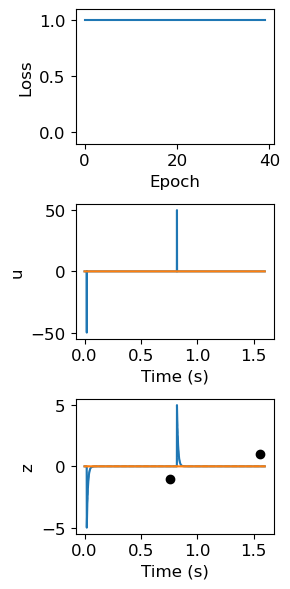

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(3, 6), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

# fig.savefig('ms/4_flip_flop_bptt_vanish_grad.svg')